# Basic analysis of MSFT financial data

Project work for Machine Learning course, June 2022<br>
Sapienza University of Rome.<br>
Accademic year: 2021-2022.

In this project we will consider daily MSFT financial data  corresponding to the time period going from October 2013 to February 2022. 
These data are initially pre-processed and subsequently used to define some prediction models.
Given day $i$, consider the price of the stock in the following 10 days $i+1,...i+10$. Our target is to predict the highest price reached by MSFT stock in each of these 10 days, given information on day $i$.

# Data collection
Data have been downloaded from https://www.marketwatch.com/investing/stock/msft/download-data. <br>
This dataset contains daily information about opening, closing, highest and lowest price of MSFT data and the amount of exchanged volume starting from October 2013 to February 2022.

In [ ]:
import pandas as pd
data = pd.read_csv('MSFT.csv')

In [2]:
data

,Date,Open,High,Low,Close,Volume
0,02/23/2022,290.18,291.70,280.10,280.27,"37,811,168"
1,02/22/2022,285.00,291.54,284.50,287.72,"41,736,121"
2,02/18/2022,293.05,293.86,286.31,287.93,"34,264,008"
3,02/17/2022,296.36,296.80,290.00,290.73,"32,461,580"
4,02/16/2022,298.37,300.87,293.68,299.50,"29,982,119"
...,...,...,...,...,...,...
2097,10/24/2013,33.82,34.10,33.57,33.72,"53,209,727"
2098,10/23/2013,34.35,34.49,33.67,33.76,"58,600,500"
2099,10/22/2013,35.02,35.10,34.52,34.58,"40,438,551"
2100,10/21/2013,34.98,35.20,34.91,34.99,"27,436,510"


In [3]:
import numpy as np
data['Volume'] = [int(np.char.replace(data['Volume'][i],',','')) for i in range(data.shape[0])]
data.rename(columns={'Date':'date', 'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace=True)
data = data.iloc[::-1].set_index(data.index)

# Feature engineering
The model that we want to build takes data of day $i$  as input and produces as output the highest price reached by MSFT stock during the following 10 days.<br>
In the next figure, the term $\texttt{next\_high\_j}[i]$  corresponds to the predicted value of day $i+j$ given information of day $i$.

<img src="schema1.png" width="700">

We want to estimate a function $f:R^m \to R^k$  where $m$ is the number of input features, while $k$ is the number of output features (number of days for which we want to predict the highest price).We need to add to the dataset the new output columns that can be built from column 'high' by shifting it backwards and sacrificing the last 10 rows of the dataset.

In [4]:
target_num = 10
for j in range(target_num):
    data[f'next_high_{j+1}'] = [data['high'][i+j+1] for i in range(data.shape[0]-j-1)] + [None for i in range(j+1)]

In [5]:
data

,date,open,high,low,close,volume,next_high_1,next_high_2,next_high_3,next_high_4,next_high_5,next_high_6,next_high_7,next_high_8,next_high_9,next_high_10
0,10/18/2013,34.82,34.99,34.33,34.96,41811699,35.20,35.10,34.49,34.10,36.29,35.73,35.72,35.79,35.69,35.69
1,10/21/2013,34.98,35.20,34.91,34.99,27436510,35.10,34.49,34.10,36.29,35.73,35.72,35.79,35.69,35.69,35.98
2,10/22/2013,35.02,35.10,34.52,34.58,40438551,34.49,34.10,36.29,35.73,35.72,35.79,35.69,35.69,35.98,36.71
3,10/23/2013,34.35,34.49,33.67,33.76,58600500,34.10,36.29,35.73,35.72,35.79,35.69,35.69,35.98,36.71,38.22
4,10/24/2013,33.82,34.10,33.57,33.72,53209727,36.29,35.73,35.72,35.79,35.69,35.69,35.98,36.71,38.22,38.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,02/16/2022,298.37,300.87,293.68,299.50,29982119,296.80,293.86,291.54,291.70,NaN,NaN,NaN,NaN,NaN,NaN
2098,02/17/2022,296.36,296.80,290.00,290.73,32461580,293.86,291.54,291.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2099,02/18/2022,293.05,293.86,286.31,287.93,34264008,291.54,291.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2100,02/22/2022,285.00,291.54,284.50,287.72,41736121,291.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# More input features

As we will see later, columns 'high', 'close', 'low', 'open' are highly correlated to each other,  so three of these features happen to be redundant, since they don't provide the model with any additional useful information. However, new input features (technical indicators) can be created from these correlated features implementing the following functions:

#### Simple moving average
#### MACD (Moving Average Convergence/Divergence)

$MACD = Ema_{12} - Ema_{26}$

Ema = Exponential moving average

$Ema_{12}[0] = close[0]$

$Ema_{12}[i] = close[i] (\frac{smoothing}{1 + 12}) + Ema_{12}[i-1] (1-(\frac{smoothing}{1+12}))$

smoothing = 2

In [6]:
import indicators as ind
data['s_m_avr_14'] = ind.simple_moving_average(data['close'],14)

smoothing = 2
ema_12 = ind.ema(data['close'],12,smoothing)
ema_26 = ind.ema(data['close'],26,smoothing)
data['ema_12'] = ema_12
data['ema_26'] = ema_26
data['macd'] = [ema_12[j] - ema_26[j] for j in range(len(ema_12))]

In [21]:
dim = data.shape[0]
date = data['date']
x_pos = np.arange(0, dim, step=500)
x_lab = date[x_pos]

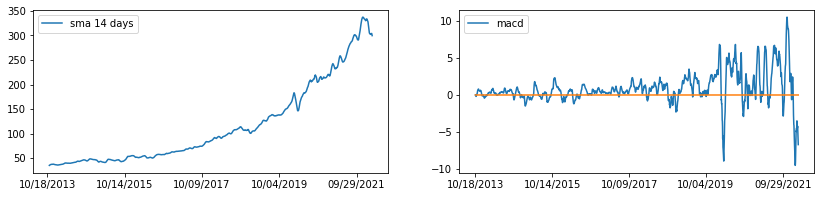

In [40]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.plot(data['s_m_avr_14'],label='sma 14 days')
plt.xticks(x_pos,x_lab) 
plt.legend()

plt.subplot(1,2,2)
plt.plot(data['macd'],label = 'macd')
plt.plot([0 for i in range(data['close'].shape[0])])
plt.xticks(x_pos,x_lab) 
plt.legend()

plt.show()

#### Average true range 

$Tr[i] = max\{(high[i]-low[i]),|high[i]-close[i-1]|,|low[i]-close[i-1]|\}$

Atr = media mobile a 14 giorni calcolata su Tr

#### Average typical price
Costruito a partire da Tp

$Tp[i] = \frac{high[i] + low[i] + close[i]}{3}$

In [26]:
data['avr_true_range'] = ind.average_true_range(data['high'],data['low'],data['close'],14)
data['typical_price'] = ind.typical_price(data['high'],data['low'],data['close'])
data['avr_typical_price'] = ind.average_typical_price(data['typical_price'],14)

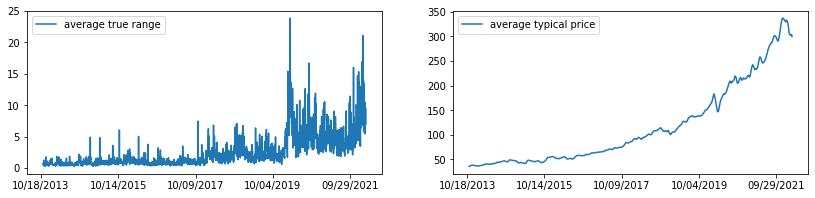

In [41]:
plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.plot(data['avr_true_range'],label = 'average true range')
plt.xticks(x_pos,x_lab) 
plt.legend()

plt.subplot(1,2,2)
plt.plot(data['avr_typical_price'],label = 'average typical price')
plt.xticks(x_pos,x_lab) 
plt.legend()

plt.show()

#### CCI = commodity channel index

$Cci[i] = \frac{Tp[i] - smatp}{0.015*avrDev}$

avrDev = deviazione standard media a 14 giorni calcolata su typical price

$avrDev = (\sum{|smatp[i]-tp[i]|})/14$

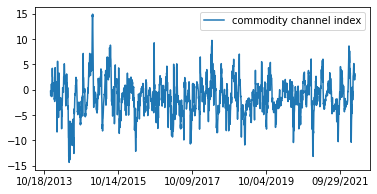

In [42]:
data['mean_dev'] = ind.mean_deviation(data['typical_price'],data['avr_typical_price'],14)
data['cci'] = ind.commodity_channel_index(data['avr_typical_price'],data['s_m_avr_14'],data['mean_dev'],14)

plt.figure(figsize=(6, 3))
plt.plot(data['cci'], label = 'commodity channel index')
plt.xticks(x_pos,x_lab) 
plt.legend()
plt.show()

# Feature selection
We can observe the following correlation matrix:

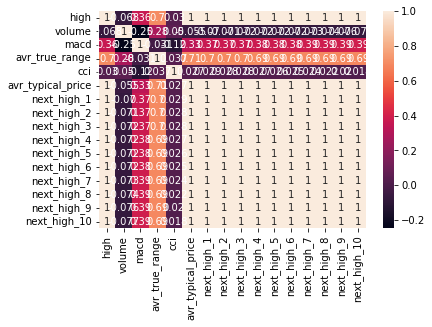

In [43]:
import seaborn as sn
correlation_matrix = data[['high','volume','macd','avr_true_range','cci','avr_typical_price']+[f'next_high_{j+1}'for j in range(target_num)]].corr()
sn.heatmap(correlation_matrix,annot=True)
plt.show()

The correlation between 'high' and 'next\_high\_10'  is a linear correlation, as the next figure makes clear.

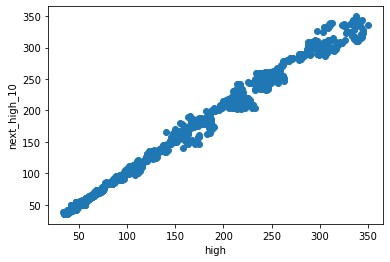

In [44]:
data1 = data['high']
data2 = data['next_high_10']
plt.scatter(data1,data2)
plt.xlabel('high')
plt.ylabel('next_high_10')
plt.show()

We can now narrow our data by deleting 'close', 'low', 'open' and  's\_m\_avr\_14' as they are highly correlated to 'high'.

In [59]:
low_corr_data = data[['high','volume','macd','avr_true_range','cci']+[f'next_high_{j+1}'for j in range(target_num)]]

# Feature selection and transformation
As for the new output column, also the new input columns produce several missing values on the first rows that must be therefore removed.<br>
Moreover, notice that some of the feature take values close to zero (for example 'cci') , while other reach much greater values (for example the quantity 'volume' can be higher than $10^8$). The dataset must be therefore centered and scaled such that each feature has mean equals to 0  and variance equals to 1.

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns = list(low_corr_data.columns)

In [61]:
low_corr_data = pd.DataFrame(scaler.fit_transform(low_corr_data),columns = columns)

In [62]:
def remove_empty_lines(data,target_num):
    m = data.shape[0]
    transformed_data = data.copy()
    transformed_data = transformed_data.drop(index = [i for i in range(43)])
    transformed_data = transformed_data.drop(index = [i for i in range(m-target_num,m)])
    return transformed_data

In [63]:
transformed_data = remove_empty_lines(low_corr_data,target_num)

In [64]:
transformed_data.isna().any()

high              False
volume            False
macd              False
avr_true_range    False
cci               False
next_high_1       False
next_high_2       False
next_high_3       False
next_high_4       False
next_high_5       False
next_high_6       False
next_high_7       False
next_high_8       False
next_high_9       False
next_high_10      False
dtype: bool

In [65]:
transformed_data

,high,volume,macd,avr_true_range,cci,next_high_1,next_high_2,next_high_3,next_high_4,next_high_5,next_high_6,next_high_7,next_high_8,next_high_9,next_high_10
43,-0.969713,0.224506,-0.472255,-0.525003,0.075317,-0.965603,-0.966548,-0.963642,-0.960262,-0.959175,-0.962519,-0.960571,-0.963201,-0.965829,-0.970266
44,-0.965137,2.143715,-0.481834,-0.742047,0.223410,-0.966084,-0.963177,-0.959789,-0.958697,-0.962064,-0.960110,-0.962739,-0.965368,-0.969803,-0.975082
45,-0.965619,-0.383629,-0.495588,-0.650660,0.188476,-0.962713,-0.959324,-0.958224,-0.961586,-0.959656,-0.962278,-0.964906,-0.969341,-0.974619,-0.979296
46,-0.962248,-1.116860,-0.488137,-0.802972,0.060536,-0.958860,-0.957758,-0.961114,-0.959178,-0.961824,-0.964445,-0.968879,-0.974157,-0.978833,-0.982065
47,-0.958395,-0.889733,-0.467956,-0.723008,0.463036,-0.957295,-0.960648,-0.958705,-0.961346,-0.963991,-0.968418,-0.973696,-0.978371,-0.981602,-0.979176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,2.384528,0.391466,-2.738224,1.295122,0.049585,2.337206,2.307463,2.295420,2.267488,2.343712,2.309385,2.250742,2.159591,2.207746,2.208102
2088,2.337689,0.869296,-2.772752,1.489319,0.569064,2.307947,2.295904,2.267967,2.344188,2.309877,2.251229,2.160077,2.208234,2.208589,2.159099
2089,2.308430,0.287770,-2.594887,4.208083,1.199155,2.296388,2.268451,2.344667,2.310353,2.251721,2.160564,2.208721,2.209077,2.159585,2.123701
2090,2.296870,-0.154308,-2.620481,2.429844,1.203777,2.268935,2.345150,2.310832,2.252197,2.161054,2.209208,2.209564,2.160072,2.124187,2.095767


# Model selection and evaluation

As we have seen before, there is a clear linear dependence between 'high' and  'next\_high\_10'. 
We want to understand how the trained model will behave with respect to this correlation.<br>
The chosen models are: a linear regressor, multilayer perceptrons, regression trees and random forests. Each model with multiple possible combination of hyperparameters is trained and evaluated with 5-fold cross-validation on the entire dataset. Each of the 5 folds is generated by allowing the cross validation method to shuffle the data points.<br>
The evaluation functions are the mean absolute percentage error (MAPE) and the mean squared error, (MSE) defined by the following formulas:
$$
MAPE(y,\hat{y})=\frac{1}{n_{samples}}\sum_{i=0}^{n_{samples}-1}\frac{|y_i - \hat{y_i}|}{max(\epsilon,|y_i|)} 
$$

$$
MSE(y,\hat{y})=\frac{1}{n_{samples}}\sum_{i=0}^{n_{samples}-1}(y_i - \hat{y_i})^2 
$$

Where $\hat{y_i}$ is the $i$-th element of $\hat{y}$, the estimated target output, and $y_i$ is the corresponding element of $y$, the correct target output.

In [66]:
X = transformed_data[['high','volume','macd','avr_true_range','cci']]
y = transformed_data[[f'next_high_{j+1}'for j in range(target_num)]]

### Hyperparameter tuning

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

kfold = KFold(n_splits=5,shuffle=True)

### Linear regressor

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

regr = LinearRegression()
scores = cross_validate(regr,X,y,scoring=('neg_mean_squared_error'),cv=KFold(n_splits=5,shuffle=True,random_state=0))
print(f"mean_squared_error = {round(-sum(scores['test_score'])/5,6)}")

scores = cross_validate(regr,X,y,scoring=('neg_mean_absolute_percentage_error'),cv=KFold(n_splits=5,shuffle=True,random_state=0))
print(f"mean absolute percentage error = {round(-sum(scores['test_score'])/5,6)}")

mean_squared_error = 0.002985
mean absolute percentage error = 0.133539


### Multi Layer Perceptrons

In [60]:
hyperparameters = [{'hidden_layer_sizes':[(5),(5,7),(5,7,10),(7),(7,10)],'max_iter':[2000],
                    'solver':['lbfgs','sgd','adam'],'learning_rate_init':[0.1,0.01,0.001],
                    'random_state':[1,2,3,4]}]

score = 'neg_mean_squared_error'
model = MLPRegressor()
regr = RandomizedSearchCV(model, hyperparameters, scoring=score, cv=kfold, n_iter=20, random_state=0)
regr.fit(X, y)

r = regr.cv_results_
p = pd.DataFrame(r['params'])
p['mean squared error'] = -r['mean_test_score']
p.drop(columns=['max_iter'],inplace=True)

In [61]:
hyperparameters = [{'hidden_layer_sizes':[(5),(5,7),(5,7,10),(7),(7,10)],'max_iter':[2000],
                    'solver':['lbfgs','sgd','adam'],'learning_rate_init':[0.1,0.01,0.001],
                    'random_state':[1,2,3,4]}]
score = 'neg_mean_absolute_percentage_error'
model = MLPRegressor()
regr = RandomizedSearchCV(model,hyperparameters, scoring=score, cv=kfold, n_iter=20,random_state=0)
regr.fit(X, y)

r1 = regr.cv_results_
p1 = pd.DataFrame(r1['params'])
p1['mean absolute percentage error'] = -r1['mean_test_score']
p1.drop(columns=['max_iter'],inplace=True)

In [77]:
pMLP = p
pMLP['mean ab. perc. error'] = p1['mean absolute percentage error']
pMLP

,solver,random_state,learning_rate_init,hidden_layer_sizes,mean squared error,mean ab. perc. error
0,sgd,3,0.010,"(7, 10)",0.004888,0.175636
1,sgd,1,0.100,"(5, 7)",0.010808,0.498543
2,adam,2,0.010,"(7, 10)",0.003328,0.144803
3,sgd,1,0.001,7,0.016531,0.419403
4,adam,3,0.100,7,0.003702,0.165831
5,lbfgs,2,0.100,"(7, 10)",0.002632,0.135630
6,lbfgs,1,0.001,"(7, 10)",0.002331,0.128278
7,lbfgs,3,0.001,"(5, 7, 10)",0.002667,0.142475
8,adam,2,0.100,5,0.003290,0.133533
9,adam,4,0.100,"(7, 10)",0.004929,0.143124


### Regression Trees

In [69]:

hyperparameters = [{'max_features': [None,'sqrt','log2'],'min_samples_leaf':[1,5,10],
                    'criterion':['squared_error','absolute_error']}]
score = 'neg_mean_squared_error'
model = DecisionTreeRegressor(random_state=0)
regr = GridSearchCV(model,hyperparameters, scoring=score, cv=kfold)
regr.fit(X, y)

r2 = regr.cv_results_
p2 = pd.DataFrame(r2['params'])
p2['mean squared error'] = -r2['mean_test_score']

In [75]:
hyperparameters = [{'max_features': [None,'sqrt','log2'],'min_samples_leaf':[1,5,10],
                    'criterion':['squared_error','absolute_error']}]
score = 'neg_mean_absolute_percentage_error'
model = DecisionTreeRegressor(random_state=0)
regr = GridSearchCV(model,hyperparameters, scoring=score, cv=kfold)
regr.fit(X, y)

r3 = regr.cv_results_
p3 = pd.DataFrame(r3['params'])
p3['mean absolute percentage error'] = -r3['mean_test_score']

In [94]:
pDT = p2
pDT['mean ab. perc. error'] = p3['mean absolute percentage error']
pDT

,criterion,max_features,min_samples_leaf,mean squared error,mean ab. perc. error
0,squared_error,None,1,0.003061,0.140995
1,squared_error,None,5,0.002565,0.156165
2,squared_error,None,10,0.002792,0.142944
3,squared_error,sqrt,1,0.030084,0.363340
4,squared_error,sqrt,5,0.035506,0.426459
5,squared_error,sqrt,10,0.075671,0.630380
6,squared_error,log2,1,0.030084,0.363340
7,squared_error,log2,5,0.035506,0.426459
8,squared_error,log2,10,0.075671,0.630380
9,absolute_error,None,1,0.003217,0.153021


### Random Forests

In [92]:
hyperparameters = [{'max_features': [None,'sqrt','log2'],'min_samples_leaf':[1,5,10],
                    'criterion':['squared_error','absolute_error'],'n_estimators':[2,20,50,100]}]
score = 'neg_mean_squared_error'
model = RandomForestRegressor(random_state=0)
regr = GridSearchCV(model,hyperparameters, scoring=score, cv=kfold)
regr.fit(X, y)
r4 = regr.cv_results_

p4 = pd.DataFrame(r4['params'])
p4['mean squared error'] = -r4['mean_test_score']
p4.sort_values(by=['mean squared error'])

,criterion,max_features,min_samples_leaf,n_estimators,mean squared error
3,squared_error,None,1,100,0.001599
2,squared_error,None,1,50,0.001621
39,absolute_error,None,1,100,0.001627
38,absolute_error,None,1,50,0.001653
1,squared_error,None,1,20,0.001676
...,...,...,...,...,...
64,absolute_error,log2,5,2,0.023818
28,squared_error,log2,5,2,0.023887
16,squared_error,sqrt,5,2,0.023887
56,absolute_error,sqrt,10,2,0.025084


In [93]:
hyperparameters = [{'max_features': [None,'sqrt','log2'],'min_samples_leaf':[1,5,10],
                    'criterion':['squared_error','absolute_error'],'n_estimators':[2,20,50,100]}]
score = 'neg_mean_absolute_percentage_error'
model = RandomForestRegressor(random_state=0)
regr = GridSearchCV(model,hyperparameters, scoring=score, cv=kfold)
regr.fit(X, y)
r5 = regr.cv_results_

p5 = pd.DataFrame(r5['params'])
p5['mean absolute percentage error'] = -r5['mean_test_score']
p5.sort_values(by=['mean absolute percentage error'])

,criterion,max_features,min_samples_leaf,n_estimators,mean absolute percentage error
39,absolute_error,None,1,100,0.117168
3,squared_error,None,1,100,0.117636
38,absolute_error,None,1,50,0.118332
2,squared_error,None,1,50,0.120160
1,squared_error,None,1,20,0.123006
...,...,...,...,...,...
68,absolute_error,log2,10,2,0.390286
28,squared_error,log2,5,2,0.390908
16,squared_error,sqrt,5,2,0.390908
32,squared_error,log2,10,2,0.465071


### More on Random Forests

We can see that random forests have the best performances on these data if the used hyperparameters are: criterion = squared error (absolute error if we consider MAPE as score function), all features used for splitting, min sample leaf = 1 and number or estimators = 100.<br>
We can therefore focus now on random forests and see how each hyperparameter affected on the final results.

For each score function (MAPE and MSE) and for each single hyperparameter (for example criterion = squared\_error) compute the mean score and the variance among all experiments where that hyperparameter is used. We can represent these computation with an errorbar-plot.

In [73]:
def error_bars(p):
    means = []
    stds = []
    x = []
    l = p.shape[1]-1
    for i in range(l):
        col = p.columns[i]
        classes = list(p[col].value_counts().index)
        for c in classes:
            a = p['score'][p[col]==c].mean()
            a_std = p['score'][p[col]==c].std()
            means.append(a)
            stds.append(a_std)
            x.append(str(c))

    m = p['score'].mean()
    m_std = p['score'].std()

    means.append(m)
    stds.append(m_std)
    x.append('overall mean')
    return means,stds,x

The plot shows average MAPE and MSE with relative variance for each fixed hyperparameter. The values reported are the negative version of the mentioned score functions, so we look at the maximum negative MSE and the maximum negative MAPE.

In [94]:
p6 = pd.DataFrame(r4['params'])
p6['score'] = r4['mean_test_score']
p6['max_features'] = p6['max_features'].fillna('all features')
p6['n_estimators'] = p6['n_estimators'].apply(lambda x: str(x)+' trees')
p6['min_samples_leaf'] = p6['min_samples_leaf'].apply(lambda x: str(x)+' (msl)')

p6.head()

,criterion,max_features,min_samples_leaf,n_estimators,score
0,squared_error,all features,1 (msl),2 trees,-0.002399
1,squared_error,all features,1 (msl),20 trees,-0.001676
2,squared_error,all features,1 (msl),50 trees,-0.001621
3,squared_error,all features,1 (msl),100 trees,-0.001599
4,squared_error,all features,5 (msl),2 trees,-0.002445


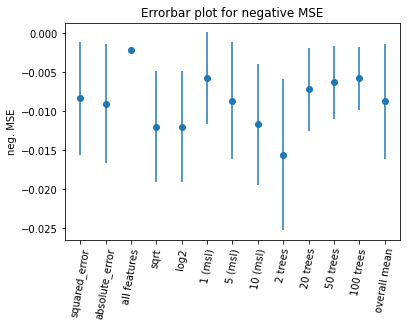

In [95]:
means,stds,x = error_bars(p6)
plt.errorbar(x=x,y=means,yerr=stds,fmt='o')
plt.xticks(rotation = 80)
plt.ylabel('neg. MSE')
plt.title('Errorbar plot for negative MSE')
plt.show()

In [96]:
p7 = pd.DataFrame(r5['params'])
p7['score'] = r5['mean_test_score']
p7['max_features'] = p7['max_features'].fillna('all features')
p7['n_estimators'] = p7['n_estimators'].apply(lambda x: str(x)+' trees')
p7['min_samples_leaf'] = p7['min_samples_leaf'].apply(lambda x: str(x)+' (msl)')

p7.head()

,criterion,max_features,min_samples_leaf,n_estimators,score
0,squared_error,all features,1 (msl),2 trees,-0.136570
1,squared_error,all features,1 (msl),20 trees,-0.123006
2,squared_error,all features,1 (msl),50 trees,-0.120160
3,squared_error,all features,1 (msl),100 trees,-0.117636
4,squared_error,all features,5 (msl),2 trees,-0.143118


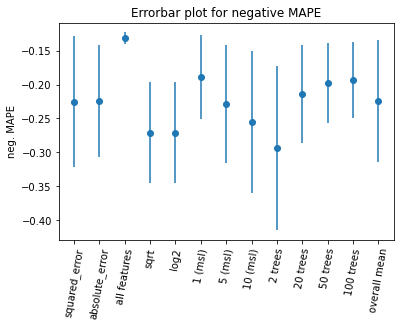

In [97]:
means,stds,x = error_bars(p7)
plt.errorbar(x=x,y=means,yerr=stds,fmt='o')
plt.xticks(rotation = 80)
plt.ylabel('neg. MAPE')
plt.title('Errorbar plot for negative MAPE')
plt.show()

It is clear from the plots how, on these data, random forests that use all feature perform better than models that use only a portion of them.
The same happens for n\_estimators: using more trees provides better results on average, as more tree help to reduce the risk of overfitting.<br>
We can also observe that for both score functions, the variance for n\_estimators = 2 in  much greater than the variance for n\_estimators = 20,50,100.<br>
This means that given $R_1$ a random forest with 2 trees with score $s_1$ and $R_2$ a random forest with 20 trees with score $s_2$, $Prob(s_2 \text{ close to } a_2)$ is greater than $Prob(s_1\text{ close to } a_1)$, where $a_1$ is the average score for random forests with 2 trees and $a_2$ is the average score for random forests with 20 trees. If, in addition, $a_2$ is greater than $a_1$, we are more motivated to choose $R_2$ rather than of $R_1$.<br>
For what concerns the term min\_sample\_leaf, allowing the leaves to have multiple data doesn't increase the model performace, that even declines as min\_sample\_leaf increases.

This last analysis confirms that the best model for fitting these data are random forests with more than 20 trees and min\_sample\_leaf = 1. The splitting criterion depends whether we want to minimize MAPE (criterion = absolute\_error) or MSE (criterion = squared\_error). <br>
For such a model it is possible to reach MAPE  = 0.117168 and MSE = 0.001599.